**Tenemos datos estandarizados de la Oferta de casas en el 2019 y el 2020**

Usaremos solo los datos del 2020 para hacer un modelo cotizador de casas. 

In [1]:
import missingno as ms
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import pickle


data_2020 = pd.read_csv('../data/casas_2020.csv')
data_2020.drop(data_2020[data_2020['latitud'].isna() == True].index,axis=0,inplace=True)

#Solo trabajremos con los datos de lima.
lima_mask = data_2020['Ciudad'].str.contains('Lima|Callao|Cañete').astype('boolean')
lima_data = data_2020[lima_mask]

lima_data.drop_duplicates(inplace=True) #Eliminamos duplicados

In [2]:
text_for_embeddings = lima_data[['Direccion','Descripcion']]  #Podemos buscar en el texto datos faltantes.

lima_data.drop(['Direccion','Descripcion'],axis=1, inplace=True)
lima_data.drop(lima_data[lima_data['Precio'].isna() ==True].index, axis=0, inplace=True)

#Creando nuevos features para datos Nulos.
lima_data['Barrio'].fillna('NoEspecifica', inplace=True)

#Eliminar todos las casas sin área
no_area_index = lima_data[(np.where(lima_data[['Area_constr','Area_total']].isnull().all(1),True,False))].index
lima_data.drop(no_area_index,inplace=True)

In [3]:
#Limpiando Precio y cambiando la moneda
TIPO_DE_CAMBIO = 3.5

lima_data['Precio'] = lima_data['Precio'].str.extract('(\d+)').astype('float32')
mask_usd = (lima_data['MONEDA'] == 'USD')

index_casas_usd = lima_data[mask_usd].index
lima_data.loc[mask_usd,'Precio'] = lima_data.loc[mask_usd,'Precio']*TIPO_DE_CAMBIO

lima_data.dropna(subset=['Precio'],axis=0,inplace=True) #Algunas casas solo tenían la moneda funcional, pero no el precio en sí.

In [4]:
#Reemplazo nulos en Area total y Area constr
for tupla_col in [('Area_total','Area_constr'),('Area_constr','Area_total')]:
    area_total_null = lima_data[lima_data[tupla_col[0]].isna()].index
    lima_data.loc[area_total_null,tupla_col[0]] = lima_data.loc[area_total_null, tupla_col[1]]

In [5]:
lima_data['Precio_m2_total'] = lima_data['Precio'] / lima_data['Area_total']
lima_data['Precio_m2_constr'] = lima_data['Precio'] / lima_data['Area_constr']

<AxesSubplot:>

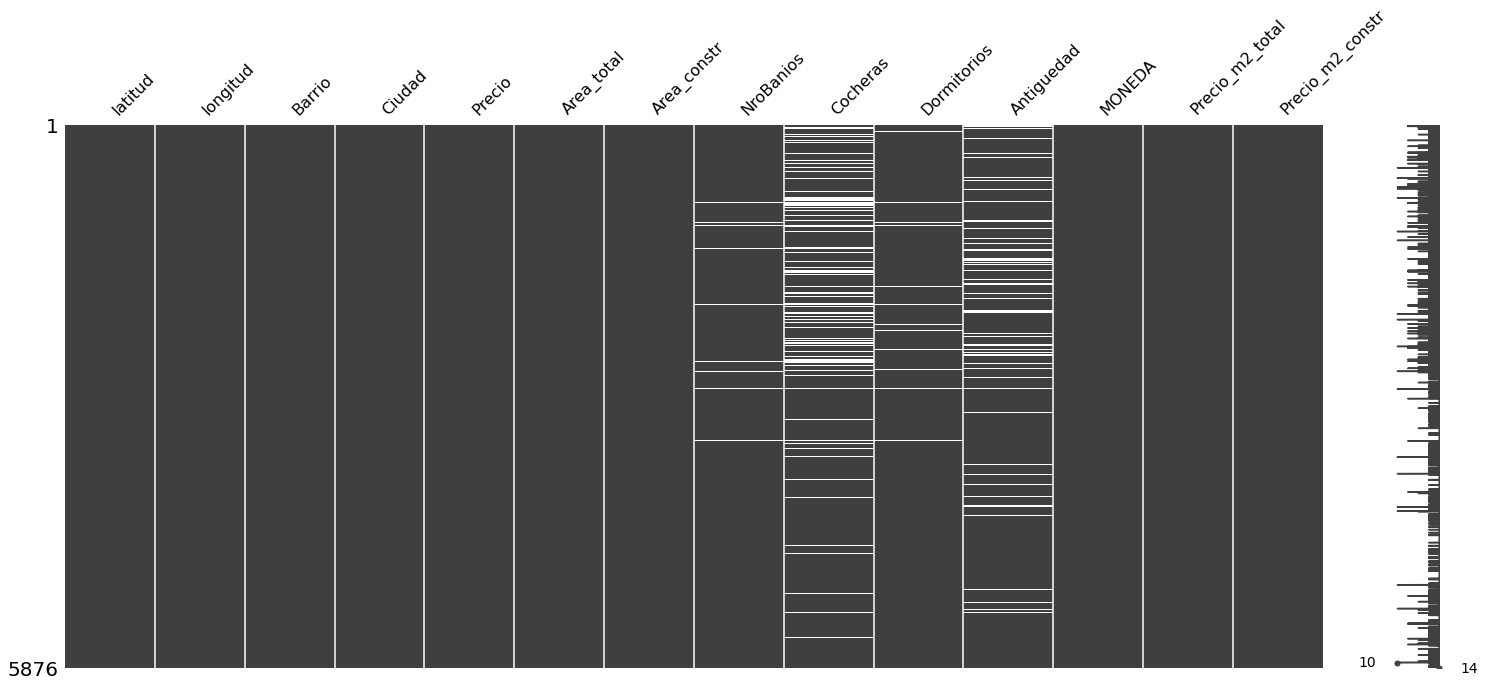

In [6]:
ms.matrix(lima_data)

###### Antes de imputar, exploraré los datos:

In [7]:
from scipy.stats import zscore
drop_ones = lima_data[lima_data['Precio'] < 10].index
lima_data.drop(drop_ones, axis=0, inplace=True)

#Los demás son metros por área cuandrada
datos_metros_2 = lima_data[lima_data['Precio'] < 65801.0].index

lima_data.loc[datos_metros_2, 'Precio'] = lima_data.loc[datos_metros_2, 'Precio']*lima_data.loc[datos_metros_2, 'Area_total']

##### Procesamiento de outliers

Para Precio, area total, area construida y precio_m2_total.

Nota: 
Los altos valores en precio_m2_total pueden corresponder a bienes de lujo, mientras que muy bajos valores en estos pueden ser terrenos.

In [8]:
#Detect and drop
precio_outliers = lima_data[(zscore(lima_data['Precio']) > 2.5)].index
lima_data.drop(precio_outliers, axis=0,inplace=True)

area_total_outliers = lima_data[(zscore(lima_data['Area_total'])>2.5)].index
lima_data.drop(area_total_outliers,axis=0, inplace=True)

area_constr_outliers = lima_data[(zscore(lima_data['Area_constr'])>2.5)].index
lima_data.drop(area_constr_outliers,axis=0, inplace=True)

precio_m2_total_outliers = lima_data[(zscore(lima_data['Precio_m2_total']) > 2.5)].index
lima_data.drop(precio_m2_total_outliers, axis=0, inplace=True)

In [9]:
#non-logic-prices
non_logic_prices = lima_data[lima_data['Precio_m2_total'] < 20].index
lima_data.drop(non_logic_prices, axis=0, inplace=True)

In [10]:
#Drop Prices
to_drop = lima_data[lima_data['Precio']>lima_data['Precio'].quantile(.985)].index
lima_data.drop(to_drop, axis=0, inplace=True)

#non logic.
non_logic_areas = lima_data[lima_data['Area_total'] == 1].index
lima_data.drop(non_logic_areas,axis=0,inplace=True)

#For Plotting
temporal_drop = lima_data[(lima_data['Area_total']>1000)].index

In [11]:
lima_data['Precio_cat'] = pd.cut(lima_data['Precio'],bins=4, labels =['bajo','medio','caro','muy caro'])

In [12]:
seven_first = lima_data['Barrio'].value_counts().iloc[0:7].keys().tolist()

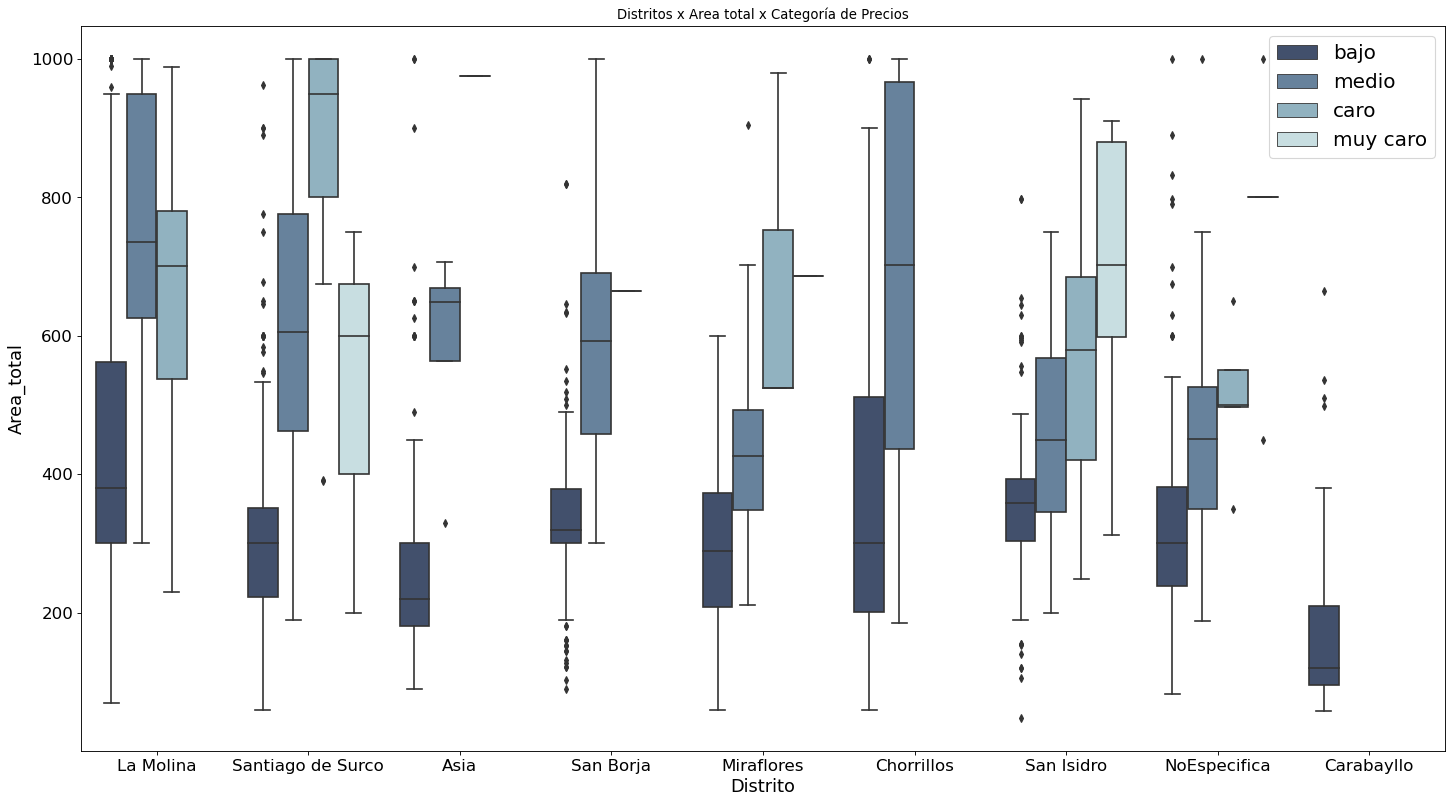

In [13]:
# BoxPlots para los 7 primeros distritos
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(22, 12), dpi=80)

seven_first = lima_data['Barrio'].value_counts().iloc[0:9].keys().tolist()
ax = sns.boxplot(x="Barrio", y="Area_total", hue="Precio_cat", 
                 data=lima_data.drop(temporal_drop)[lima_data.drop(temporal_drop)['Barrio'].isin(seven_first)],
                palette="ch:r=-.2,d=.3_r")

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(prop=dict(size=18))
ax.set_xlabel(r'Distrito', fontsize=16)

ax.set_ylabel(r'Area_total', fontsize=16)
ax.set_title(r'Distritos x Area total x Categoría de Precios')

plt.savefig('EDA_images_2020/Boxplot_distritos.png')

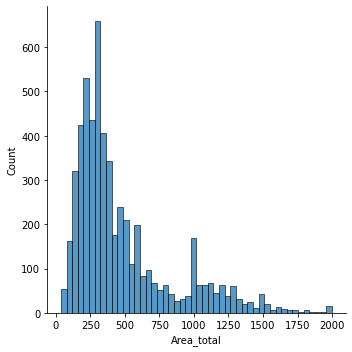

In [14]:
sns.displot(lima_data[lima_data['Area_total']<lima_data['Area_total'].quantile(.97)]['Area_total'])

<AxesSubplot:xlabel='Precio', ylabel='Area_constr'>

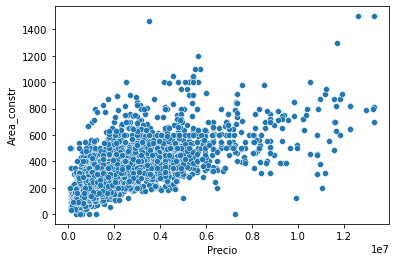

In [15]:
sns.scatterplot(x='Precio',y='Area_constr', data = lima_data.drop(temporal_drop,axis=0))

#### Criterios para limpiar los nulos: 

- Cruzar variables categorizadas de Area_constr y Barrio para determinar el nro de baños, cocheras, dormitorios y antiguedad según frecuencia de cruce.

*El cruce se hace con KBinsDiscretizer porque en el pipeline final se tiene que volver a transformar el input del cliente. En el caso de Precio_cat no se hizo porque no se tiene que volver a hacer.

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile') #Con Strategy tengo más flexibilidad.

#Tengo que hacer reshape para no tener los valores en una fila, sino todos en una columna. Es como un transpose.
discretizer.fit(lima_data['Area_constr'].values.reshape(-1,1))

KBinsDiscretizer(encode='ordinal', n_bins=20)

In [17]:
lima_data['Area_constr_cat'] = discretizer.transform(lima_data['Area_constr'].values.reshape(-1,1))

In [18]:
with open('../data/discretizer.pkl','wb') as handle:
    pickle.dump(discretizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
#Reemplazamos los nulos.

for column in ['NroBanios','Dormitorios','Antiguedad','Cocheras']:
    to_merge_for_nan = lima_data.dropna().groupby(['Area_constr_cat','Barrio'])[column].agg(lambda x: round(x.mean())).reset_index()
    to_merge_for_nan[column].fillna(0)
    
    lima_data = lima_data.merge(to_merge_for_nan, on=['Area_constr_cat','Barrio'], how='inner', suffixes=('_DROP','')).filter(regex='^(?!.*_DROP)')
    
    lima_data[column].fillna(0)

In [20]:
lima_data.dropna(inplace=True)
lima_data.isna().sum()

latitud             0
longitud            0
Barrio              0
Ciudad              0
Precio              0
Area_total          0
Area_constr         0
MONEDA              0
Precio_m2_total     0
Precio_m2_constr    0
Precio_cat          0
Area_constr_cat     0
NroBanios           0
Dormitorios         0
Antiguedad          0
Cocheras            0
dtype: int64

In [22]:
lima_data.to_csv('../data/2020_Notebook01_clean_data.csv',index=False)